In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Notebook for analyzing electron-impact ionization of $H_2$ in rswarp

## Import needed modules

In [2]:
%matplotlib inline

import sys
import math
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, e, m_e
from rswarp.utilities import file_utils

## Load output data generated by ionization.py

In [3]:
path = 'diags-1.000keV/hdf5/'
full =  file_utils.loadparticlefiles(path)

#print full[1000]['H2+'][0,:]
## Output is array of size 7: x, ux, y, uy, z, uz, 1.0 (gamma?)
#print full[1000]['H2+'][:,6] - 1

#step_min = min(full.keys())
#step_max = max(full.keys())

## Assume uniform spacing
#step_interval = step_max  / len(full.keys())

## Grab simulation attributes we'll need 
#ff = h5.File(path + 'data00001000.h5', 'r')
#beam_sw = np.average(ff['data/1000/particles/e-/weighting'])  # Macroparticle weight of beam
#ion_sw = np.average(ff['data/1000/particles/H2+/weighting'])  # Macroparticle weight of ions
#timestep = ff['data/1000'].attrs['dt']
#ff.close()

## Plot angular distribution of emitted electrons

Uses output data generated by defining writeAngleDataDir and setting writeAnglePeriod=1

Total number of ionization events:  72945 72945.0


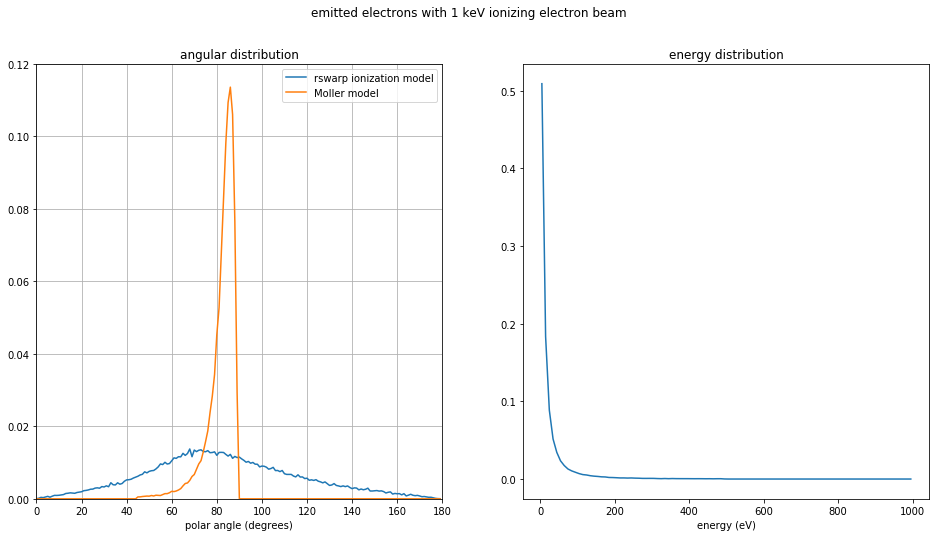

In [4]:
ionization_analysis_fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))

plt.suptitle('emitted electrons with 1 keV ionizing electron beam')

ax1.set_title('angular distribution')
ax1.set_xlabel('polar angle (degrees)')
ax1.set_xlim(0.0, 180.0)
ax1.set_ylim(0.0, 0.12)
ax1.grid(True)

ax2.set_title('energy distribution')
ax2.set_xlabel('energy (eV)')
#ax2.set_xlim(0.0, 180.0)
#ax2.set_ylim(0.0, 0.12)

nstep = sorted(full.keys())[-1]
#print nstep; sys.exit(0)
#nstep = 1000
f = h5py.File('./diags-1.000keV/angledata.h5', 'r')

ang_bins = np.zeros((2, 180))
energy_bins = np.zeros((100))

for i in range(nstep):
    tmp = f['data/' + str(i+1) + '/e-/emitted e-/incidentvelocities'][:]
#    tmp = f['data/' + str(i+1) + '/e-/H2+/incidentvelocities'][:]
    if tmp.size > 0:
        n = tmp.size / 3
        u0 = np.reshape(tmp, (n, 3))
        u1 = np.reshape(f['data/' + str(i+1) + '/e-/emitted e-/emittedvelocities'][:], (n, 3))
        for j in range(n):
            sqr = lambda x: x * x
            costheta = (u0[j,0] * u1[j,0] + u0[j,1] * u1[j,1] + u0[j,2] * u1[j,2])
            costheta /= math.sqrt(sqr(u0[j,0]) + sqr(u0[j,1]) + sqr(u0[j,2]))
            costheta /= math.sqrt(sqr(u1[j,0]) + sqr(u1[j,1]) + sqr(u1[j,2]))
            thetadeg = 180. / math.pi * math.acos(costheta)
            if math.isnan(thetadeg):
                print 'Simulation data', costheta, u0[j,:], u1[j,:]
            else:
                ang_bins[0, math.trunc(thetadeg)] += 1
            c2 = sqr(c)
            eps = lambda u0, u1, u2: m_e * c2 * (math.sqrt(1.0 + (sqr(u0) + sqr(u1) + sqr(u2)) / c2) - 1.0)
            eps0 = eps(u0[j,0], u0[j,1], u0[j,2])
            eps1 = eps(u1[j,0], u1[j,1], u1[j,2])
            energy_bins[math.trunc(0.1 * eps1 / e)] += 1
#            if eps1 / e < 100.:
#                energy_bins[math.trunc(1.0 * eps1 / e)] += 1
            costheta = eps1 * (eps0 + 2.0 * m_e * c2)
            costheta /= eps0 * (eps1 + 2.0 * m_e * c2)
            costheta = math.sqrt(costheta)
            thetadeg = 180. / math.pi * math.acos(costheta)
            if math.isnan(thetadeg):
                print 'Moller model, ', costheta, u0[j,:], u1[j,:]
            else:
                ang_bins[1, math.trunc(thetadeg)] += 1
print 'Total number of ionization events: ', math.trunc(ang_bins[0, :].sum()), energy_bins.sum()
ang_bins[0, :] /= ang_bins[0, :].sum() # Unity-integral normalization
ang_bins[1, :] /= ang_bins[1, :].sum()
energy_bins /= energy_bins.sum()
ax1.plot(ang_bins[0, :], label='rswarp ionization model')
ax1.plot(ang_bins[1, :], label='Moller model')
#plt.legend(prop = {'size': 10}, loc = 'upper right')
ax1.legend(loc = 'upper right')
ax2.plot(np.linspace(5., 995., 100), energy_bins)
#ax2.plot(energy_bins)
#plt.tight_layout()
plt.savefig('ionization_analysis.png')
plt.show()

## How to generate an angle from cross section

    emitted_energy - emitted electon energy (in eV)
    incident_energy - incident electon energy (in eV)
    nnew - number of new particles

    Selection of after-ionization angles for the primary and secondary electrons
    adapted from XOOPIC's [3] MCCPackage::primarySecondaryAngles routine.

The cross-section $\sigma(w, t, \theta)$ dictates the likelihood of any given ionization event with incident energy $t$, emission energy $w$, and emission angle $\theta$.  We will treat the recoiling primary as though it is two separate particles, one before and one after ionization, with energy reduced by the ionization energy and what is given to the secondary.

Note: theta is defined relative to the incident electron trajectory

We know that:
$ \int_0^\pi { \sigma(w, t, \theta) * 2\pi sin(\theta) d\theta } = \sigma(t,w) $

We can then define $F(\theta)$ taking the value $0 <= F(\theta) <= 1$:
$ F(\theta) = 2\pi \int_0^\theta d\theta' sin(\theta') \frac{\sigma(w, t, \theta')}{\sigma(w,t)} $

If we can invert this expression to get $\theta$ as a function of $w, t$, and $F(\theta)$, we can
sample this distribution by choosing a random number for $F(\theta)$ and the known values of $w, t$.

This inversion is explained in detail in [4].